# Call Center Operations 🧏

### Objective: Demand-Forecasting Analysis
One main problem that a data science team is tasked with solving is demand-forecasting for a company call center. We maximize efficiency by ensuring we are staffed appropriately to meet demand (ensuring a good customer experience), while also not overstaffing.

### Success Criteria
Please prepare a 90-day daily minutes forecast

### Summary
When looking high level at the dataset, it appears that the trend of interpreting time is downward, with undetectable seasonality. However, upon closer inspection, Day of Week seasonality emerged as a key feature, with Monday having the highest need for interpreters, with a gradual slope downward until a steep drop-off during the weekend. 

Using this information, a Random Forest Regression model was able to achieve an R2 value of 0.91, accounting for roughly 82% of the variance in Interpreting time. However, because the forecasted interpreting times are lower than expected, further model development would be beneficial prior to scheduling the support staff. One reason this may be the case is that the Service Level was assumed to be at the goal value of 70% which has not always historically been achieved.  

### Discussion
1. **Feature Selection**
 - Since few features were provided, it was necessary to create seasonality features to better understand minute trends in the data
2. **Model/Method Selection**
 - While an ARIMA forecast is more typical for a time series challenge, I chose to use other algorithms that had a higher level of interpretability and familiarity. 
3. **Accuracy**
 - Although the model returned a R2 value when comparing with the test set, a visual inspection shows a steep drop off during the forecasting period. One possible explanation is that the Service Level was set to a constant of 70%, which was not consistently seen during the observation period and that may account for a difference in the forecast with future reality.
4. **How you will continue to monitor accuracy**
 - With any time series, the more data, the better. Especially given that the world has undergone vast transformations in the digital space during the time period (see COVID-19 pandemic), further distance from the height of that pandemic and the economic instability arising from that disruption will help to provider more accurate forecasts. 
5. **What you would do with more time**
 - I would spend more time and energy looking at the ARIMA and SARIMA algorithms. Additionally, I would love to be able to examine how further internal data could refine this analysis. Of course, more global factors suc as brand awareness and macroeconomic factors could also have a significant impact.  

# 1. Data Import and Validation 🗒️
The dataset contains these features: 

| Column Name | Type | Details |
|:--------|:--------|:--------|
|  DateOfPeriod   |  Date   |  Call Center Dates of Operations between May 8, 2019 and June 15, 2023 |
|  InterpretingTime   |  Float64   |  Time spent (minutes) interpreting calls during the corresponding DateOfPeriod.  |
|  ServiceLevel   |  Float64   | Proportion of calls serviced (answered) within 30 seconds. The goal is to always hit 70%  |

First, we import the necessary libraries for data manipulation and visualization, and then load the dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Set seaborn as style
import statsmodels.api as sm
import matplotlib
# !pip install pmdarima # If package is needed in environment
import pmdarima as pm
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore') # Clean up the warning for the publication

# Import the datafiles, parsing the date, and saving the date as the index
df_InterpretingTime = pd.read_csv('test_problem_data_1.csv', index_col = 0,parse_dates = ['DateOfPeriod'])
df_ServiceLevel = pd.read_csv('test_problem_data_2.csv', index_col = 0,parse_dates = ['DateOfPeriod'])

# Join the dataframes by DateOfPeriod column
df = df_InterpretingTime.merge(df_ServiceLevel, on = 'DateOfPeriod').sort_values(by = 'DateOfPeriod',ascending = True)

df.sort_values(by = 'DateOfPeriod',ascending = False)

,InterpretingTime,ServiceLevel
DateOfPeriod,,
2023-06-15,132234.49,0.627
2023-06-14,137751.00,0.671
2023-06-13,144783.38,0.651
2023-06-12,166753.90,0.655
2023-06-11,30959.85,0.640
...,...,...
2019-05-12,44567.65,0.699
2019-05-11,54895.06,0.698
2019-05-10,139771.40,0.670


# 2. Data Cleaning and Exploration 🧹
Since the principle of "garbage in garbage out" is well established, the first step is to ensure data accuracy and get a top level view of data trends. 

### 2.1 Check for Missing and Duplicate Values ✍️

In [2]:
# Check for missing values
null = df.isnull().sum()

# Check for duplicates
dup = df.duplicated().sum()

print(f"Missing Values: \n {null} \n \n Duplicates: {dup}")

Missing Values: 
 InterpretingTime    0
ServiceLevel        0
dtype: int64 
 
 Duplicates: 0


As can be seen above, the data contain no missing or duplicate values. Proceed with data exploration 

### 2.2 Examine current trends 📈
Within any time series, it is important to check for key features within the data, namely the Trend, Seasonality, and Noise. The statsmodels library contains a function that is capable of easily decomposing these features

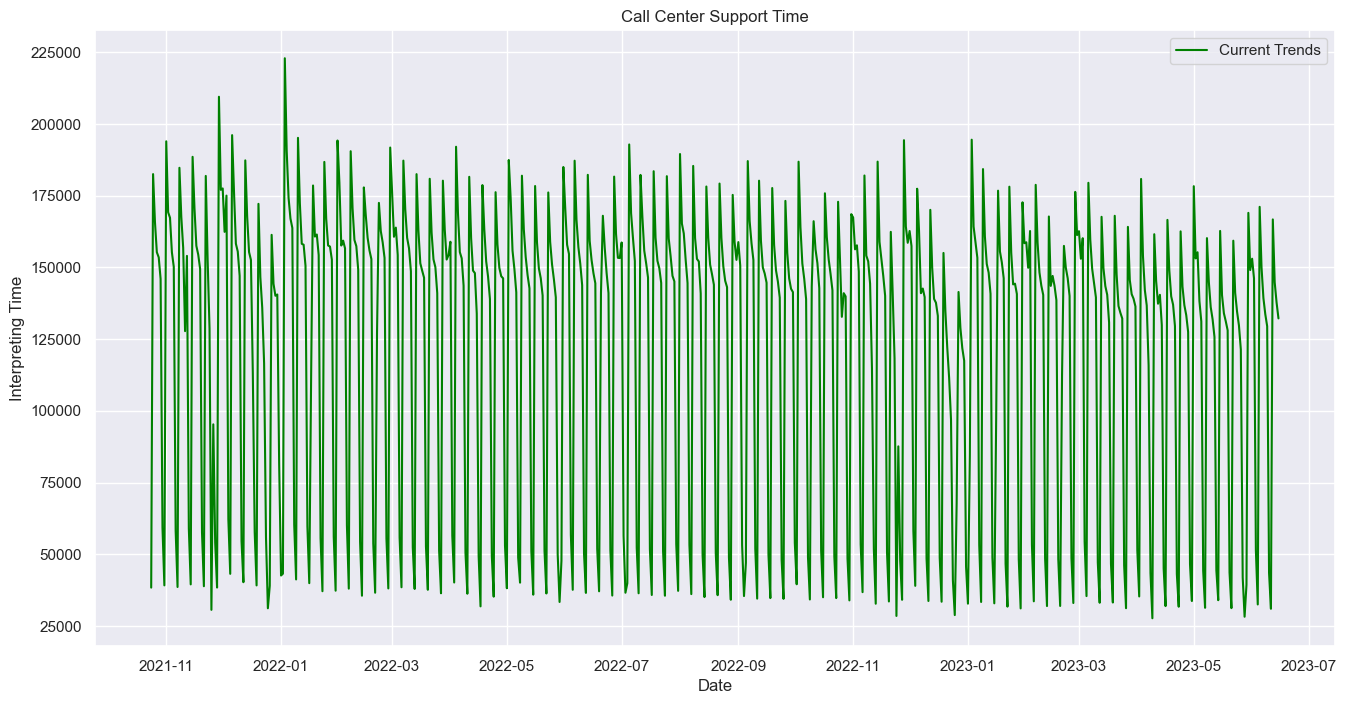

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8)) # Adjust figure size
plt.plot(df.index[-600:], df['InterpretingTime'].tail(600), color='green', label = 'Current Trends')
plt.title('Call Center Support Time')
plt.xlabel('Date')
plt.ylabel('Interpreting Time')
plt.legend()
plt.grid(True)
plt.show()

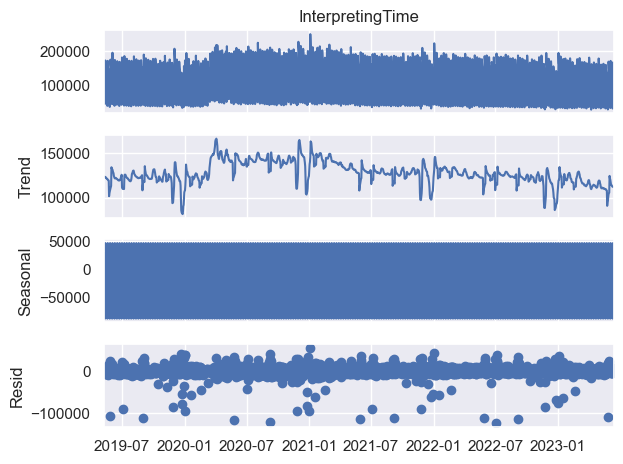

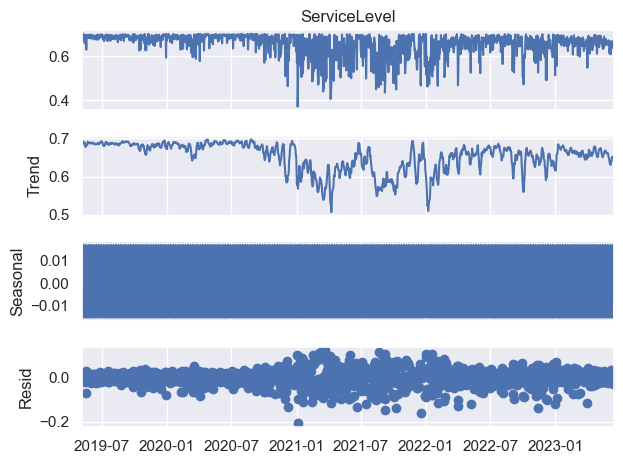

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# First, select the numerical types for the data (overkill for this 2 feature set but useful for generalizable code)
cols = df.select_dtypes(include = ['float64']).columns

# Looping through each numerical column
for i, col in enumerate(cols):
    components = seasonal_decompose(df[col])
    fig = components.plot()
    plt.show()

### 2.3 Feature Creation for Seasonality ✐
Although the seasonal_decompose function above did not reveal any strong seasonality, it is logical that a support center would experience seasonality and so features will be extracted from the date column such as day of week, quarter, month, and year. 

In [5]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df

df = create_features(df)
df

,InterpretingTime,ServiceLevel,dayofweek,dayofmonth,dayofyear,weekofyear,month,quarter,year
DateOfPeriod,,,,,,,,,
2019-05-08,150929.20,0.694,2,8,128,19,5,2,2019
2019-05-09,148711.44,0.689,3,9,129,19,5,2,2019
2019-05-10,139771.40,0.670,4,10,130,19,5,2,2019
2019-05-11,54895.06,0.698,5,11,131,19,5,2,2019
2019-05-12,44567.65,0.699,6,12,132,19,5,2,2019
...,...,...,...,...,...,...,...,...,...
2023-06-11,30959.85,0.640,6,11,162,23,6,2,2023
2023-06-12,166753.90,0.655,0,12,163,24,6,2,2023
2023-06-13,144783.38,0.651,1,13,164,24,6,2,2023


One place where support centers typically display seasonality is in the **day of the week**, let's take a look. 

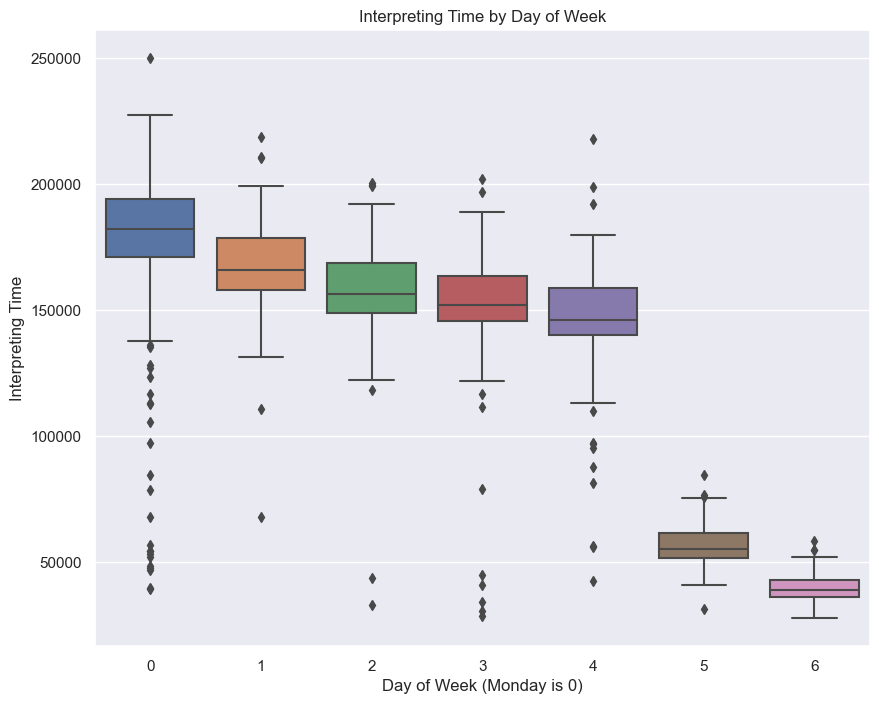

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='InterpretingTime')
ax.set_title('Interpreting Time by Day of Week')
plt.xlabel('Day of Week (Monday is 0)')
plt.ylabel('Interpreting Time')
plt.show()

As suspected, there is a **high level of seasonality** in the day of week, with the greatest call volume occuring on Monday and then gradually decreasing before a steep drop off during the weekend.


# 3. Model Selection and Fit 📓
Because this is a time-series analysis, it makes the most sense to use the ARIMA algorithm.

### 3.1 Train / Test Split and Future data 🧮
In order to be prepared to run the algorithm we need to create a number of samples within the dataset. First of all will be the training and test sets, with 90% of the data going into training and the most recent 10% being used as the test data. 

In [7]:
from sklearn.preprocessing import StandardScaler

train_test_percent = 0.90 # Test the model on the last 10% of the data
train_data, test_data = df[0:int(len(df)*train_test_percent)], df[int(len(df)*train_test_percent):] # Split into 90/10 
X_train = train_data.drop(columns = ['InterpretingTime']) # Pull the X training data out
X_test = test_data.drop(columns = ['InterpretingTime'])   # Pull the X testing data out
y_train = train_data['InterpretingTime']                  # Pull the y training data out
y_test = test_data['InterpretingTime']                    # Pull the y testing data out

Additionally, a dataframe containing the future data also needs to be created. This contains the next **90 days** following the observed data. While most of the features are derivatives of the date, there isn't much work that needs to be done to impute the missing exogenous values, however, the Service Level needs attention. The goal for the Service Level is **70%** and so that will be inserted for the entire forecast period. 

In [8]:
n_forecast = 90 # Want to create a forecast for 90 future days
start_date = df.index.max() + timedelta(days=1) # Start at the day after the observed data
future_dates = pd.DataFrame(pd.date_range(start_date, periods = n_forecast), 
                            columns = ['DateOfPeriod']).set_index('DateOfPeriod')

future_dates['ServiceLevel'] = 0.7 # This is the service level goal. 
future_dates = create_features(future_dates) # Add in the seasonality feature set
future_dates

,ServiceLevel,dayofweek,dayofmonth,dayofyear,weekofyear,month,quarter,year
DateOfPeriod,,,,,,,,
2023-06-16,0.7,4,16,167,24,6,2,2023
2023-06-17,0.7,5,17,168,24,6,2,2023
2023-06-18,0.7,6,18,169,24,6,2,2023
2023-06-19,0.7,0,19,170,25,6,2,2023
2023-06-20,0.7,1,20,171,25,6,2,2023
...,...,...,...,...,...,...,...,...
2023-09-09,0.7,5,9,252,36,9,3,2023
2023-09-10,0.7,6,10,253,36,9,3,2023
2023-09-11,0.7,0,11,254,37,9,3,2023


### 3.2 Using ARIMA to get high level view of trends ➕
ARIMA (**A**uto**R**egressive **I**ntegrated **M**oving **A**verage is one of the most common ways of working with time series data. Here is a brief explanation
 - AutoRegressive: A model that regresses on its own lagged values. i.e., predicts **future values based on past values**
 - Integrated: The goal is to obtain **stationary data** (i.e., not subject to trend or seasonality). An Augmented Dickey-Full (ADF) test is helpful in determining whether data is stationary
 - Moving Average: Using a rolling average helps to **smooth out the noise**
 
Choosing the right p,d,q parameters for an ARIMA model can be complicated. Using the pmdarima package below, perform a search of the best parameters by minimizing the AIC. 

In [9]:
## Use auto_arima to find optimal parameters
import pmdarima as pm

arima = pm.auto_arima(y_train,
                      seasonal=True, m=7, # Seasonal at the daily level
                      d=1, D=1, start_p=1, start_q=1, max_p=3, max_q=3, # Put in starting and end values
                      trace=True, suppress_warnings=True, stepwise=True)
# Print out summary information on the fit
print(arima.summary())
print(arima.params)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=31732.695, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=31169.299, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.95 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=31446.189, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=31055.358, Time=0.52 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=31254.977, Time=0.37 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=30956.196, Time=0.56 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=31066.848, Time=0.37 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.38 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.71 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=30921.955, Time=1.18 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=31025.072, Ti

Using the selected model above, train and fit the **optimal SARIMA model** to the data and create predictions

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

base_order = (3, 1, 0)                        # Create the p, d, q
seasonal_order = (2, 1, 0, 7)                 # Create the P, D, Q, and seasonality
history = [x for x in y_train]                # Get a list of all the dates in the training set
predictions = list()                          # Create an empty list to store predictions
model = ARIMA(history, order=base_order,
             seasonal_order = seasonal_order) # Using all of the training data, train an ARIMA model
model_fit = model.fit()                       # Fit the model
yhat = model_fit.forecast()[0]                # Get the first forecast
predictions.append(yhat)                      # Place the prediction into list
history.append(y_train[0])                    # Add the next day into the data for the rolling average

Now that we have a baseline model from the training data, we can use that model to start making predictions.

The following code goes item by item, adding one of the observed test data every time and making the next prediction based on the most recent. 

In [11]:
# rolling predictions for test set
for i in range(1, len(y_test)):
    model = ARIMA(history, order=base_order,
             seasonal_order = seasonal_order) # Using all of the previous data, create an ARIMA model 
    model_fit = model.fit()                   # Fit the model
    yhat = model_fit.forecast()[0]            # Get the next forecast value
    predictions.append(yhat)                  # Save the next prediction
    obs = y_test[i]                           # Get the observed value
    history.append(obs)                       # Save the observed value into the history for future rolling forecast

**Model Fit**: Looking at a few of the key metrics, we can examine our model fit

In [12]:
# report performance
mse = mean_squared_error(y_test, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print('RMSE: '+str(rmse))

MSE: 314335458.7758818
MAE: 10026.911873257039
RMSE: 17729.50813688529


As seen above, the ARIMA model as executed above **does not have great model fit** (we want each of those values to be as small as possible). That makes sense considering that it didn't use any seasonality or features in the data. It was just meant to give a **high level view of the time series**. With that in mind, let's keep going to see the predictions. 

Using the trained and tested model, create a future forecast for the **next 90 days**. 

In [13]:
future_arima = pd.Series(model_fit.predict( start = 1, end = n_forecast)) # Predict for the next 90 days

future_arima.index = future_dates.index
future_arima.head()

DateOfPeriod
2023-06-16     85310.876927
2023-06-17    113598.439631
2023-06-18    118064.201965
2023-06-19    103673.477118
2023-06-20     80244.426508
dtype: float64

Putting everything together, create a graph that shows the observed data and the predictions

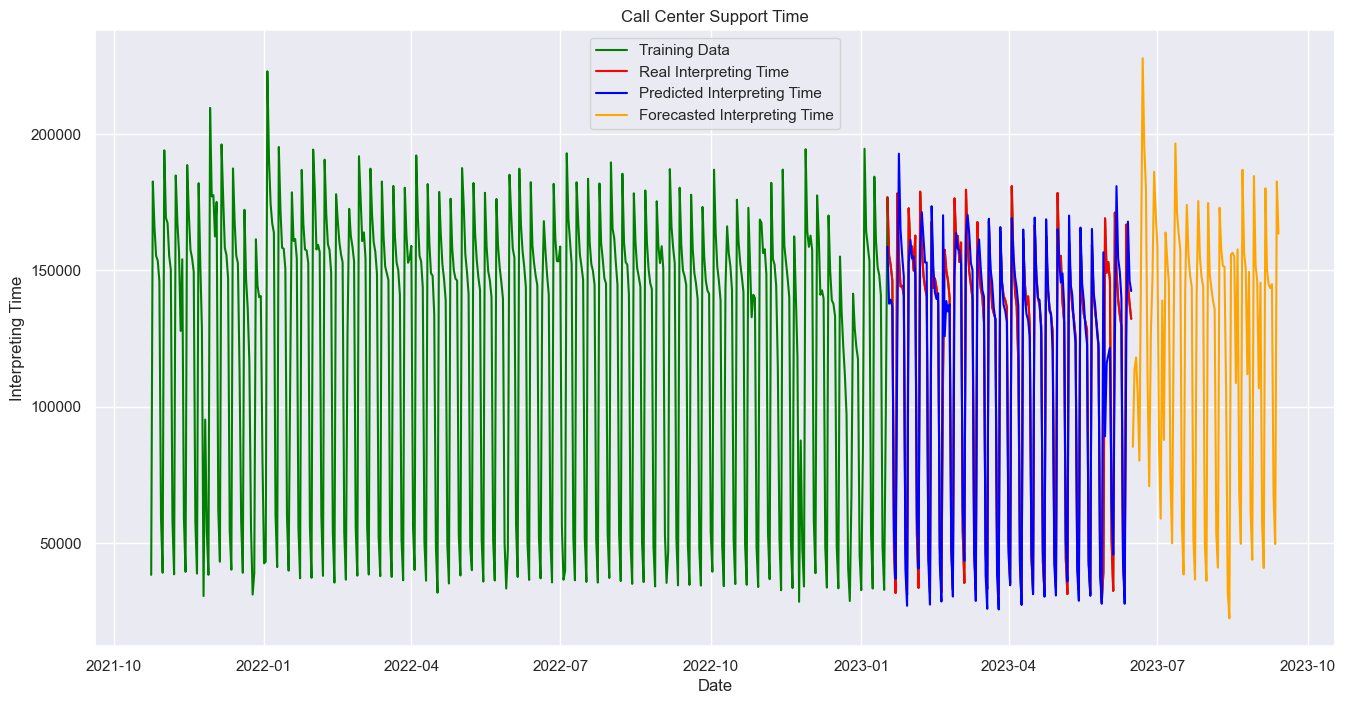

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8)) # Adjust figure size
plt.plot(df.index[-600:], df['InterpretingTime'].tail(600), color='green', label = 'Training Data')
plt.plot(test_data.index, y_test, color = 'red',                           label = 'Real Interpreting Time')
plt.plot(test_data.index, predictions, color = 'blue',                     label = 'Predicted Interpreting Time')
plt.plot(future_arima.index, future_arima, color = 'orange',               label = 'Forecasted Interpreting Time')
plt.title('Call Center Support Time')
plt.xlabel('Date')
plt.ylabel('Interpreting Time')
plt.legend()
plt.grid(True)
plt.show()

Although the predictions look pretty accurate, because of the limitions in model fit and because the above model does not take into account any of the features (like Service Level or the Day of Week seasonality), it is time to try other models. 

### 3.3 Exploration of Other Models 🌳
Other more general machine learning algorithms can also be used to analyze time series data. The below pipeline will look at a number of these algorithms and choose the best one

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics


#Create a list with all the models
model_pipeline = []
model_pipeline.append(LinearRegression()) # Most basic Regression model
model_pipeline.append(DecisionTreeRegressor(random_state=123)) # Most basic tree model
model_pipeline.append(KNeighborsRegressor()) # Can be good at finding patterns in the data
model_pipeline.append(RandomForestRegressor(random_state=123)) # More robust tree model
model_pipeline.append(GradientBoostingRegressor()) # Most computationally expensive and robust tree model

Now use the created pipeline to find the optimal algorithm

In [16]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#Create the list of models and the accuracy of each model
model_list = ['Linear Regression', 'Decision Tree', 'KNN', 'Random Forest','XGBoost']
training_r2_score_list = [] # Create empty lists to store model fit values
mean_cross_val_mse=[]

for model in model_pipeline:
    model.fit(X_train, y_train) # Fit the model
    y_pred = model.predict(X_test) # Create predictions for the model
    training_r2_score_list.append(model.score(X_train, y_train))  # R2 score for training data
    
    # Negative Mean Squared Error for cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_cross_val_mse.append(-scores.mean())

# Compare the performance of the models in a dataframe
result_df = pd.DataFrame({'Model': model_list, 'Training R2 Score': training_r2_score_list, 'Cross Validation MSE': mean_cross_val_mse})
result_df.sort_values(by = 'Cross Validation MSE',ascending = True) # Minimize the error

,Model,Training R2 Score,Cross Validation MSE
4,XGBoost,0.957565,4.334764e+08
3,Random Forest,0.987484,4.494517e+08
1,Decision Tree,1.000000,6.313590e+08
0,Linear Regression,0.708968,1.046056e+09
2,KNN,0.780966,1.546784e+09


Based on the results above, either an XGBoost or a Random Forest would probably be the best option. Now use a Grid Search approach to find the best results below

In [17]:
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# GB_opt_params={
#     'n_estimators':[500,1000,2000],
#     'learning_rate':[.001,0.01,.1],
#     'max_depth':[1,2,4],
#     'subsample':[.5,.75,1]
# }
# gb = GradientBoostingRegressor()
# gb_cv = RandomizedSearchCV(gb,GB_opt_params, cv=KFold(n_splits = 5, shuffle = True, random_state = 123))
# gb_cv.fit(X_train,y_train)
# print("The best GB score is {:.2f} with parameters: {}".format(gb_cv.best_score_,gb_cv.best_params_))

In [18]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
RF_opt_params= { 
    'n_estimators': np.arange(100,200,10),
    'max_depth' : np.arange(5,15,1),
    'max_features': ['sqrt', 'log2']
    }
rf = RandomForestRegressor()
rf_cv = GridSearchCV(rf,RF_opt_params, cv=KFold(n_splits = 5, shuffle = True, random_state = 123))
rf_cv.fit(X_train,y_train)
print("The best RF score is {:.2f} with parameters: {}".format(rf_cv.best_score_,rf_cv.best_params_))


The best RF score is 0.92 with parameters: {'max_depth': 13, 'max_features': 'log2', 'n_estimators': 100}


Using the experimentation above to do a Grid Search of the parameters and find the best ones, I have determined that the **Random Forest Regressor** with the below parameters is the optimal algorithm for these data. 

In [19]:
from sklearn.metrics import mean_squared_error
# reg = GradientBoostingRegressor(subsample= 0.75, n_estimators= 500, max_depth= 2, learning_rate= 0.01)
reg = RandomForestRegressor(max_depth= 10, max_features= 'log2', n_estimators= 150)
reg.fit(X_train, y_train) # Fit the best model

RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=150)

In [20]:
tree_predictions = reg.predict(X_test) # Predict the test data

**Model Fit**: Looking at a few of the key metrics, we can examine our model fit

In [21]:
# report performance
mse = mean_squared_error(y_test, tree_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, tree_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, tree_predictions))
print('RMSE: '+str(rmse))

MSE: 274249682.2577693
MAE: 12113.089730837304
RMSE: 16560.48556829688


As can be seen from comparisons, the model fit from the Random Forest is **comparable** to the ARIMA model, suggesting that incorporating more features into the ARIMA model might prove to be the best method for increasing accuracy and confidence in the predictions

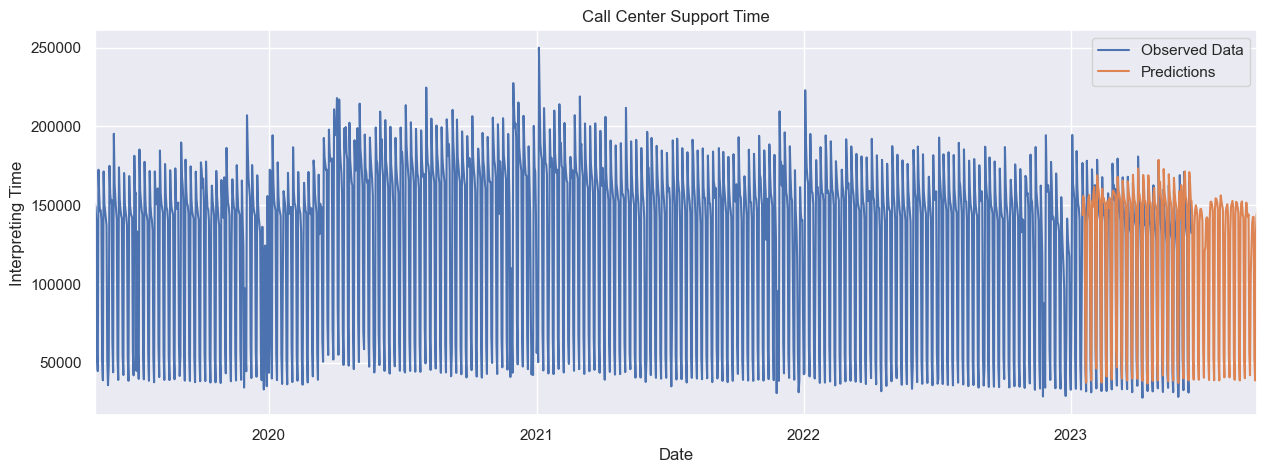

In [22]:
import warnings
warnings.filterwarnings('ignore') # Clean up the warning for the publication

test_data['prediction'] = tree_predictions # Predict the test data
future_tree = future_dates # Copy the dataframe to prevent versioning
future_tree['prediction'] = reg.predict(future_tree) # Forecast the future data

df_final = df.merge(test_data[['prediction']], how='left', left_index=True, right_index=True) # Join predictions
df_final = pd.concat([df_final,future_tree]).sort_values(by = 'DateOfPeriod',ascending = False) # UNION in the future forecast


ax = df_final[['InterpretingTime']].plot(figsize=(15, 5)) # Graph the observed and predicted values
df_final['prediction'].plot(ax=ax)
plt.legend(['Observed Data', 'Predictions'])
plt.title('Call Center Support Time')
plt.xlabel('Date')
plt.ylabel('Interpreting Time')
plt.show()

Above is the final graph for the Tree regression model. Overall, it looks like the predicted data matches the test data well but the forecasting period appears to be conservative. From this, I would want to jump deeper into the ARIMA and find a better way to account for the seasonality in the day of week data. 

### Feature Importance for Tree Models
A key component of explainable and useful AI is an analysis of feature importance. This allows the data scientist to view how each feature is contributing to the overall model. One reason why I prefer the tree models is that it allows for easy access to feature importances. 

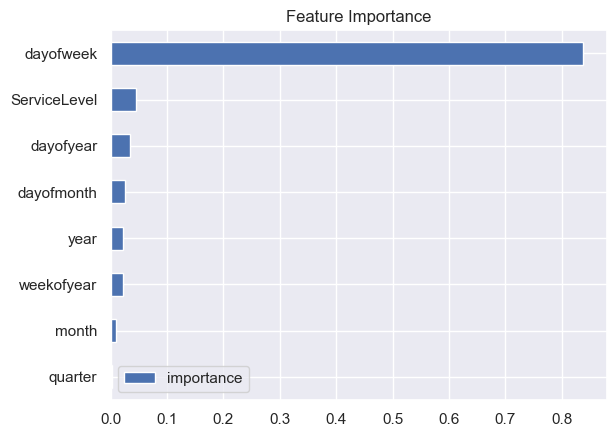

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_, # Pull out the feature importances and graph them 
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

As seen above, it appears that Day of Week is the most important feature, followed by Service Level and then other seasonality trends. It is important to note that Service Level might play a bigger difference in the model if it wasn't treated as a constant (e.g., 70%). 

### The End. Thank you for your time! 🎇